In [1]:
#기본 모듈 불러오기
import os
import json
import pandas as pd
from pandas import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# 전처리
- json 형태 값 -> 데이터 프레임으로 변환
- 'date','visitStartTime': datetime으로 변경
    - 'visitStartTime' : POSIX time (협정 세계시 1970년 1월 1일 00:00:00부터 경과한 시간을 초로 환산)
- 범주형 변수 인코딩

In [2]:
# json 형태 -> 데이터 프레임으로 변환
def load_df(csv_path='../input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource'] 
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

train_df = load_df('C:/Users/82104/Desktop/스파르타_데이터부트캠프/VSCODE/과제2/train.csv')

Loaded train.csv. Shape: (903653, 55)


In [3]:
# 열 drop
df = train_df.drop(['socialEngagementType','visitId','sessionId','device_browser','device_browserVersion','device_operatingSystem','device_browserSize','device_operatingSystemVersion',
        'device_mobileDeviceBranding','device_mobileDeviceModel','device_mobileInputSelector','device_mobileDeviceInfo','device_mobileDeviceMarketingName',
        'device_flashVersion','device_language','device_screenColors','device_screenResolution','geoNetwork_subContinent','geoNetwork_region','geoNetwork_metro',
        'geoNetwork_city','geoNetwork_cityId','geoNetwork_networkDomain','geoNetwork_networkLocation',
        'trafficSource_adwordsClickInfo.criteriaParameters','trafficSource_referralPath','trafficSource_adwordsClickInfo.page','trafficSource_adwordsClickInfo.gclId',
        'trafficSource_adwordsClickInfo.isVideoAd','trafficSource_adContent','trafficSource_campaignCode'], axis=1)


In [4]:
# date 열 int형 -> 날짜형으로 변경
df['date'] = pd.to_datetime(df['date'],format='%Y%m%d')
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'],unit='s')


#int형으로 변환
# 값이 없는 cell 전처리
df['totals_visits'] = df['totals_visits'].fillna(0)
df['totals_hits'] = df['totals_hits'].fillna(0)
df['totals_pageviews'] = df['totals_pageviews'].fillna(0)
df['totals_bounces'] = df['totals_bounces'].fillna(0)
df['totals_newVisits'] = df['totals_newVisits'].fillna(0)
df['totals_transactionRevenue'] = df['totals_transactionRevenue'].fillna(0)

# int변환
df['totals_visits'] = df['totals_visits'].astype(int)
df['totals_hits'] = df['totals_hits'].astype(int)
df['totals_pageviews'] = df['totals_pageviews'].astype(int)
df['totals_bounces'] = df['totals_bounces'].astype(int)
df['totals_newVisits'] = df['totals_newVisits'].astype(int)
df['totals_transactionRevenue'] = df['totals_transactionRevenue'].astype(float)

#df['totals_transactionRevenue'] = np.power(df['totals_transactionRevenue'], 1/6).round(2)


In [ ]:
# 범주형 변수 -> 수치형 변수로 변환
# 인코딩 하는 이유: 범주형 변수를 넣는 경우 에러가 발생할 수 있어 수치형으로 변환하는 과정이 필요하다

# 라벨인코딩
"""
label_encoder = LabelEncoder()
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    df[col] = label_encoder.fit_transform(df[col])

df.head(3)
"""

## 요일, 시간대별 사용자
- 0: 월요일, 1: 화요일, ..., 6: 일요일

In [ ]:
df['day_of_week'] = df['date'].dt.dayofweek
df['hour_of_day'] = df['visitStartTime'].dt.hour


In [ ]:
# 각 요일별 사용자 수 계산
users_per_day = df.groupby('day_of_week')['fullVisitorId'].nunique()

# 그래프 그리기
plt.figure(figsize=(10, 6))
users_per_day.plot(kind='bar', color='skyblue')
plt.title('Number of Users per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Users')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [ ]:
# 각 시간대별 이용자 수 계산
users_per_hour = df.groupby('hour_of_day')['fullVisitorId'].nunique()

# 그래프 그리기
plt.figure(figsize=(10, 6))
users_per_hour.plot(kind='bar', color='skyblue')
plt.title('Number of Users per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# x축: 시간 y축: 요일
pivot_table = df.pivot_table(index='day_of_week', columns='hour_of_day', values='fullVisitorId', aggfunc='count')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='Blues', annot=False, fmt='d')
plt.title('Number of Users by Hour and Day of the Week')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(rotation=45)
plt.yticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

## DAU /WAU /MAU 구하기

In [5]:
# 날짜 정리
import datetime as dt 
df['date_of_day']= df['visitStartTime'].dt.date
df['date_of_weekday']= df['visitStartTime'].dt.isocalendar().week
df['date_of_month']= df['visitStartTime'].dt.month
df['date_of_year']= df['visitStartTime'].dt.year


### DAU

Text(0.5, 1.0, 'Day Active Users(DAU)')

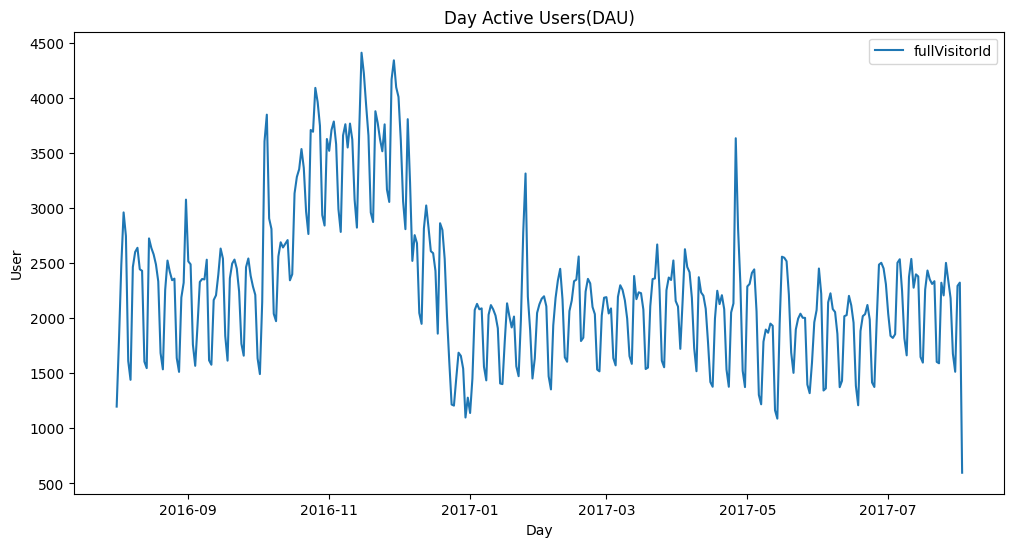

In [6]:
#DAU 구하기
df_DAU = df.groupby(df['date_of_day'])['fullVisitorId'].nunique()

plt.figure(figsize=(12,6))
df_DAU.plot(kind='line',legend='fullVisitorId')
plt.xlabel('Day')
plt.ylabel('User')
plt.legend()
plt.title('Day Active Users(DAU)')

In [7]:
df_DAU.head(3)

date_of_day
2016-08-01    1197
2016-08-02    1799
2016-08-03    2481
Name: fullVisitorId, dtype: int64

### WAU
- 31주차 ~ : 2016년
- 1 ~ 30주차 : 2017년

Text(0.5, 1.0, 'Week Active Users(WAU)')

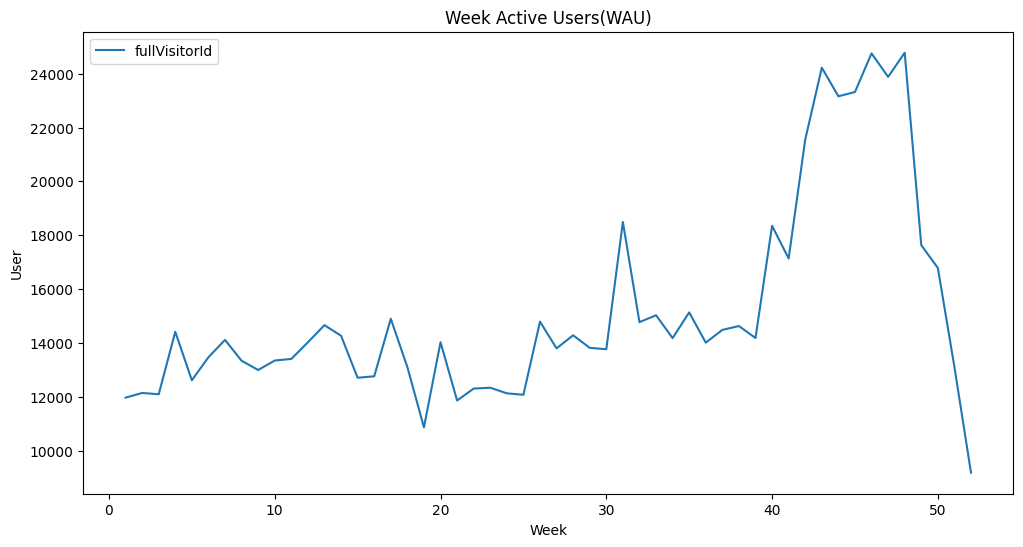

In [9]:
#WAU 구하기

df_WAU = df.groupby(df['date_of_weekday'])['fullVisitorId'].nunique()

plt.figure(figsize=(12,6))
df_WAU.plot(kind='line',legend='fullVisitorId')
plt.xlabel('Week')
plt.ylabel('User')
plt.legend()
plt.title('Week Active Users(WAU)')

In [ ]:
# 새시도 중
t_df = df.drop(['channelGrouping', 'date', 'visitNumber','visitStartTime', 'device_isMobile', 'device_deviceCategory',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_latitude',
       'geoNetwork_longitude', 'totals_visits', 'totals_hits',
       'totals_pageviews', 'totals_bounces', 'totals_newVisits',
       'totals_transactionRevenue', 'trafficSource_campaign',
       'trafficSource_source', 'trafficSource_medium', 'trafficSource_keyword',
       'trafficSource_isTrueDirect', 'trafficSource_adwordsClickInfo.slot',
       'trafficSource_adwordsClickInfo.adNetworkType'],axis=1)

In [ ]:
t_df

In [ ]:
start_date = pd.to_datetime('2016-08-01')
end_date = pd.to_datetime('2017-07-31')

# 주차별 시작일과 종료일 계산
week_start_dates = pd.date_range(start=start_date, end=end_date, freq='W-MON')
week_end_dates = pd.date_range(start=start_date + pd.DateOffset(days=6), end=end_date - pd.DateOffset(days=1), freq='W-SUN')

# 데이터프레임 생성
week_df = pd.DataFrame({
    'week': range(1, len(week_start_dates) + 1),
    'start_day': week_start_dates,
    'end_day': week_end_dates
})

week_df

## MAU
- 8월 ~ 12월: 2016년
- 1월 ~ 7월 : 2017년

Text(0.5, 1.0, 'Month Active Users(MAU)')

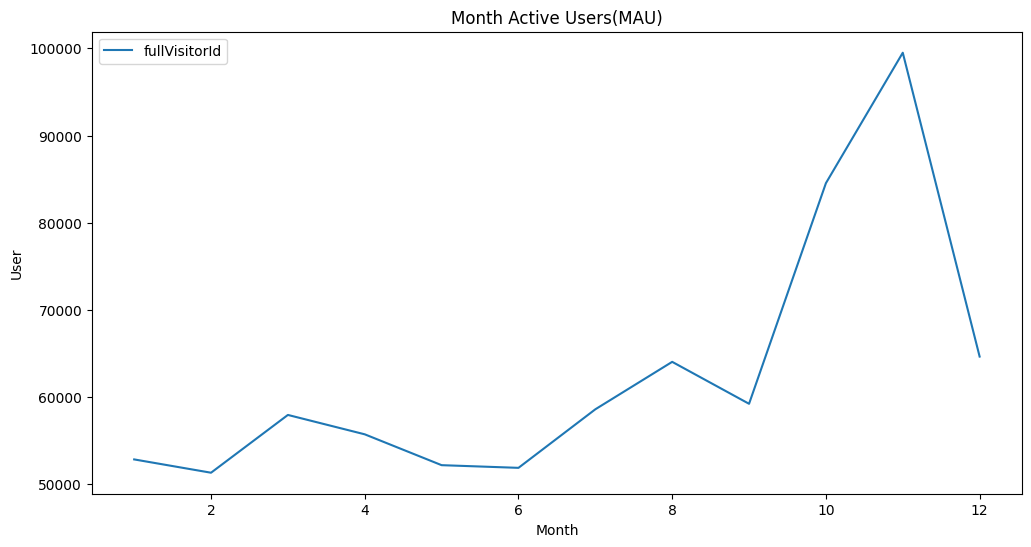

In [10]:
#MAU 구하기
df_MAU = df.groupby(df['date_of_month'])['fullVisitorId'].nunique()

plt.figure(figsize=(12,6))
df_MAU.plot(kind='line',legend='fullVisitorId')
plt.xlabel('Month')
plt.ylabel('User')
plt.legend()
plt.title('Month Active Users(MAU)')

In [ ]:
# 새로운 도전 중


## Stickiness

In [11]:
#df_DAU = df_DAU.reset_index()
#df_WAU = df_WAU.reset_index()
#df_MAU = df_MAU.reset_index()

In [ ]:
df_DAU['date_of_day'] = pd.to_datetime(df_DAU['date_of_day'],format='%Y%m%d')
df_DAU['month'] = df_DAU['date_of_day'].dt.month
df_DAU['week'] = df_DAU['date_of_day'].dt.isocalendar().week

df_merge = pd.merge(df_DAU,df_WAU,left_on='week',right_on='date_of_weekday')
df_merge = pd.merge(df_merge,df_MAU,left_on='month',right_on='date_of_month')

# Stickiness(w) = DAU / WAU
df_merge['Stickiness(w)'] = round(df_merge['fullVisitorId_x'] / df_merge['fullVisitorId_y'] * 100,2)

# Stickiness(m) = DAU / MAU
df_merge['Stickiness(m)'] = round(df_merge['fullVisitorId_x'] / df_merge['fullVisitorId'] * 100,2)

print('Stickiness(w) : ',round(df_merge['Stickiness(w)'].mean(),2) ,'Stickiness(m) : ',round(df_merge['Stickiness(m)'].mean(),2))


## 방문 주차에 따른 코호트 생성 및 weekly 리텐션 구하기
- 보유 데이터: 2016.8.1 ~ 2017.8.1

In [ ]:
# 유저들이 평균 몇일 뒤 재 방문 하는지 확인하기

#fullVisitorId,date 기준으로 정렬하기
df_sorted = df.sort_values(['fullVisitorId', 'date'])

#유저별 방문 간격 계산
df_sorted['visit_interval'] = df_sorted.groupby('fullVisitorId')['date'].diff().dt.days

# 재방문하지 않은 유저 없애기
df_sorted = df_sorted.dropna(subset=['visit_interval'])
df_sorted = df_sorted[df_sorted['visit_interval'] != 0]

# 각 유저 평균 재방문 날짜 구하기
mean_return_interval = df_sorted.groupby('fullVisitorId')['visit_interval'].mean()
overall_mean_return_interval = mean_return_interval.mean()

print(mean_return_interval)
print(overall_mean_return_interval)

In [ ]:
df_sorted.head(3)